# LFW Dataset facenet pretrained model evaluation

### Step 1, load pretrained model and dataset

In [1]:
%%capture
import tensorflow as tf
import os
from models import inception_resnet_v1
from utils import *
import numpy as np

# Setup model.
model = inception_resnet_v1
image_batch = tf.placeholder(tf.uint8, shape=[None, 160, 160, 3], name='images')
image = (tf.to_float(image_batch) - 127.5) / 128.0
prelogits, _ = model.inference(image, 1.0, False, bottleneck_layer_size=512)
embeddings = tf.nn.l2_normalize(prelogits, 1, 1e-10, name='embeddings')

# Load frozen mdoel weights.
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, 
              "/tf/FaceAdvTransfer/models/facenetLFW/model-20180402-114759.ckpt-275")

In [2]:
victim_imgdir = "/tf/FaceAdvTransfer/source_imgs"
target_imgdir = "/tf/LFW/lfw_mtcnnpy_160/Arnold_Schwarzenegger"
victim_imgs = load_imgdir(victim_imgdir)
target_imgs = load_imgdir(target_imgdir)

In [ ]:
model_in = image_batch
model_out = embeddings
def model_infer_func(input_):
    prelogits, _ = model.inference(input_, 1.0, False, bottleneck_layer_size=512)
    embeddings = tf.nn.l2_normalize(prelogits, 1, 1e-10)
    
    return embeddings

### Step 2, compute embeddings of target images

In [3]:
target_embeddings = infer_imgs(target_imgs, sess,
                               model_in, model_out, 
                               batch_size=16)

### Step 3, detect faces in victim images

In [4]:
detector = Detector()
bouding_boxes = []
cropped_victim_faces = []

for victim in victim_imgs:
    scaled_face, bbox = detector.detect(victim)
    bouding_boxes.append(bbox)
    cropped_victim_faces.append(scaled_face)

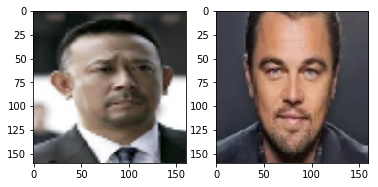

In [10]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.subplot(121)
plt.imshow(cropped_victim_faces[0])
plt.subplot(122)
plt.imshow(cropped_victim_faces[1])

### Step 4, perform modified pgd attack

In [ ]:
from attacks.pgd import pgd_attack

# Build up adv attack workflow.
adv_face = pgd_attack(model_in, model_infer_func, target_embeddings)

adv_faces = infer_imgs(cropped_victim_faces, sess, 
                       model_in, adv_face, 
                       batch_size=16)

In [21]:
int(embeddings.shape.as_list()[-1]*0.8)

409